# Классификация текста с помощью трансформеров: сравнительный анализ с традиционными методами

# **Автор**: Никита  
#  **Дата**: Август 2025  
# **Email**: greenpenguinkaa@gmail.com  

Аннотация Цель данной работы — разработка системы аномальной детекции в промышленном оборудовании с использованием вариационных автокодировщиков (VAE) на основе SECOM Dataset (UCI ML Repository).

The purpose of this work is to develop an anomaly detection system in industrial equipment using variational autoencoders (VAE) based on the SECOM Dataset (UCI ML Repository).

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt

# Загрузка данных SECOM
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
labels_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'

if not os.path.exists('secom.data'):
    os.system(f'wget -q {data_url}')
if not os.path.exists('secom_labels.data'):
    os.system(f'wget -q {labels_url}')

data = pd.read_csv('secom.data', delim_whitespace=True, header=None)
labels = pd.read_csv('secom_labels.data', delim_whitespace=True, header=None)

# Согласуем размеры данных и меток
print(f"Изначальные размеры: data={data.shape}, labels={labels.shape}")

# Приводим метки к числовому типу, неконвертируемые в NaN
y_numeric = pd.to_numeric(labels[0], errors='coerce')
print(f"Пропущенных значений в метках: {y_numeric.isna().sum()}")

/tmp/ipython-input-31586099.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('secom.data', delim_whitespace=True, header=None)


Изначальные размеры: data=(1567, 590), labels=(1567, 2)
Пропущенных значений в метках: 0


/tmp/ipython-input-31586099.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv('secom_labels.data', delim_whitespace=True, header=None)


In [ ]:
# Фильтруем данные и метки, чтобы убрать строки с пропусками в метках
mask = ~y_numeric.isna()
data = data.loc[mask].reset_index(drop=True)
y_numeric = y_numeric.loc[mask].reset_index(drop=True)

print(f"Размеры после фильтрации: data={data.shape}, labels={y_numeric.shape}")

# Удаляем колонки с пропусками более 50%
thresh = int(data.shape[0] * 0.5)
data = data.dropna(axis=1, thresh=thresh)
data = data.fillna(data.median())

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(data)

# Приводим метки к бинарным: 1 - аномалия, 0 - нормальный пример
y = np.where(y_numeric == 1, 1, 0)

print(f"Распределение меток: {np.unique(y, return_counts=True)}")

Размеры после фильтрации: data=(1567, 590), labels=(1567,)
Распределение меток: (array([0, 1]), array([1463,  104]))


In [ ]:
# Делим на train (только нормальные) и тест (все)
X_train = X[y == 0]
X_test = X
y_test = y

print(f"Train set size (нормальные): {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Определение модели VAE с кастомным слоем потерь
input_dim = X_train.shape[1]
latent_dim = 10
beta = 1.0

inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(128, activation='relu')(inputs)
h = layers.Dense(64, activation='relu')(h)

z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_h1 = layers.Dense(64, activation='relu')
decoder_h2 = layers.Dense(128, activation='relu')
decoder_out = layers.Dense(input_dim)

h_decoded = decoder_h1(z)
h_decoded = decoder_h2(h_decoded)
outputs = decoder_out(h_decoded)

Train set size (нормальные): 1463
Test set size: 1567


In [ ]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        x, x_decoded, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded), axis=1)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        loss = tf.reduce_mean(reconstruction_loss + self.beta * kl_loss)
        self.add_loss(loss)
        return x_decoded

outputs_with_loss = VAELossLayer(beta=beta)([inputs, outputs, z_mean, z_log_var])

In [ ]:
vae = Model(inputs, outputs_with_loss)
vae.compile(optimizer='adam')
vae.summary()

# Обучение
history = vae.fit(X_train, epochs=50, batch_size=128, validation_split=0.1, verbose=2)

# Оценка
X_pred = vae.predict(X_test)
recon_error = np.mean(np.square(X_test - X_pred), axis=1)

auc = roc_auc_score(y_test, recon_error)
print(f"\nROC AUC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, recon_error)
f1_scores = [f1_score(y_test, recon_error > thr) for thr in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold: {best_threshold:.4f}, Best F1: {f1_scores[best_idx]:.4f}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 562)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │     72,064 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 10)        │        650 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 10)        │        650 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 10)        │          0 │ dense_23[0][0],   │
│                     │                   │            │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │        704 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │      8,320 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 562)       │     72,498 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_3    │ (None, 562)       │          0 │ input_layer_3[0]… │
│ (VAELossLayer)      │                   │            │ dense_27[0][0],   │
│                     │                   │            │ dense_23[0][0],   │
│                     │                   │            │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 163,142 (637.27 KB)

 Trainable params: 163,142 (637.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 - 5s - 499ms/step - loss: 5.9070 - val_loss: 35.7399
Epoch 2/50
11/11 - 0s - 8ms/step - loss: 2.0043 - val_loss: 20.1720
Epoch 3/50
11/11 - 0s - 9ms/step - loss: 1.5075 - val_loss: 25.7573
Epoch 4/50
11/11 - 0s - 10ms/step - loss: 1.2669 - val_loss: 26.2226
Epoch 5/50
11/11 - 0s - 12ms/step - loss: 1.1246 - val_loss: 19.0430
Epoch 6/50
11/11 - 0s - 13ms/step - loss: 1.0387 - val_loss: 15.3470
Epoch 7/50
11/11 - 0s - 12ms/step - loss: 0.9793 - val_loss: 13.7457
Epoch 8/50
11/11 - 0s - 8ms/step - loss: 0.9368 - val_loss: 12.5386
Epoch 9/50
11/11 - 0s - 8ms/step - loss: 0.9046 - val_loss: 11.0457
Epoch 10/50
11/11 - 0s - 9ms/step - loss: 0.8794 - val_loss: 11.2380
Epoch 11/50
11/11 - 0s - 8ms/step - loss: 0.8601 - val_loss: 10.1453
Epoch 12/50
11/11 - 0s - 8ms/step - loss: 0.8438 - val_loss: 10.3085
Epoch 13/50
11/11 - 0s - 13ms/step - loss: 0.8307 - val_loss: 9.5738
Epoch 14/50
11/11 - 0s - 14ms/step - loss: 0.8198 - val_loss: 8.9670
Epoch 15/50
11/11 - 0s - 11ms/step - 

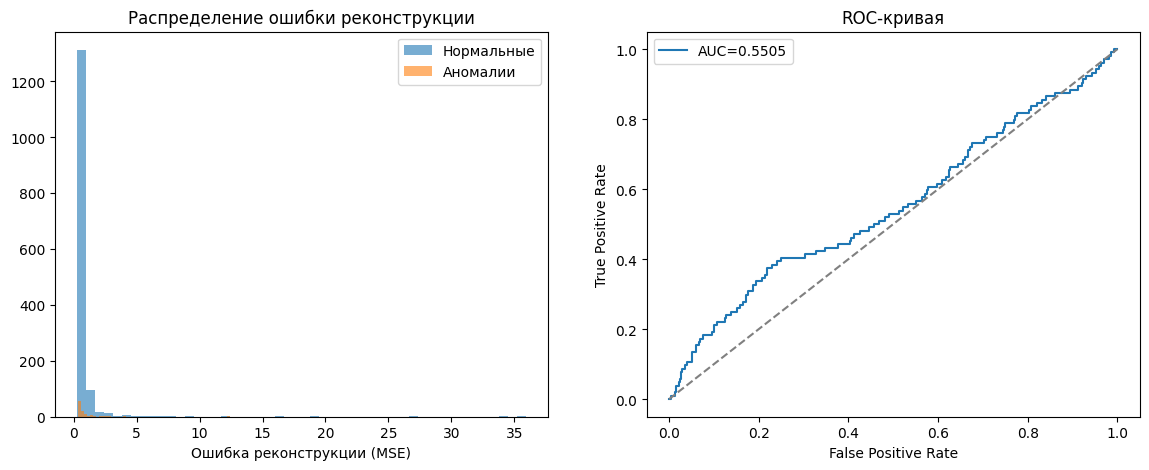

In [ ]:
# Визуализация
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.title("Распределение ошибки реконструкции")
plt.hist(recon_error[y_test == 0], bins=50, alpha=0.6, label='Нормальные')
plt.hist(recon_error[y_test == 1], bins=50, alpha=0.6, label='Аномалии')
plt.legend()
plt.xlabel("Ошибка реконструкции (MSE)")

plt.subplot(1,2,2)
plt.title("ROC-кривая")
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()